# Research Chapter 3.2: Initial investigations

In [1]:
import numpy as np
from utils import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

## Generate Data

In [2]:

target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func)

In [3]:
# rs = PSOOptim(c1=0.1, c2=0.3, w=0.9, n_iters=100, visualize=True, n_particles=10)
# gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1, 1)))
# gpr_rs.fit(X.T, y[...,None])
# y_pred = gpr_rs.predict(X.T)

# x_grid, y_grid, z_grid = get_likelihood_grids(gpr_rs)
# rs.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO_vogel.mp4")

In [4]:
# from IPython.display import Video

# Video("PSO.mp4")

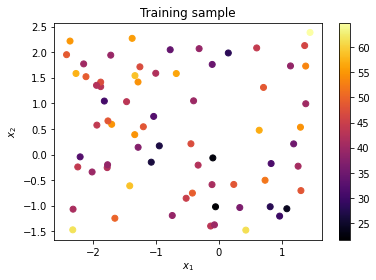

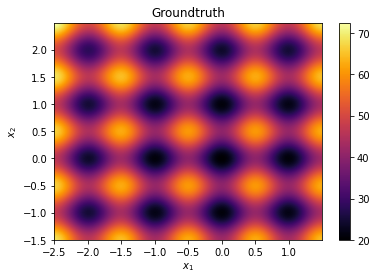

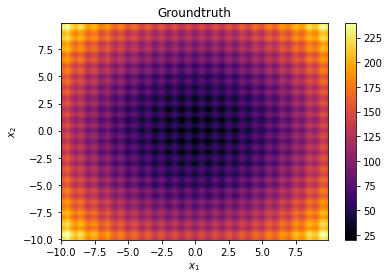

In [5]:
plt.scatter(X[0], X[1], c=y, cmap="inferno")
plt.title("Training sample")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.colorbar()
plt.show()

# plt.figure(dpi=600)
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.show()

# plt.figure(dpi=600)
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
m = np.arange(-10,10,0.1)
p = np.arange(-10,10,0.1)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.show()

## GPR with Differential Evolution

In [6]:
optim = DEOptim()
gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,1)))
gpr_de.fit(X.T, y[...,None])
y_pred = gpr_de.predict(X.T)

In [7]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_de.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -34146.92764070177
          Mean Squared Error: 9.980455128479559e-17
          R2 Score: 1.0
          MAPE: 1.5868692428038978e-10



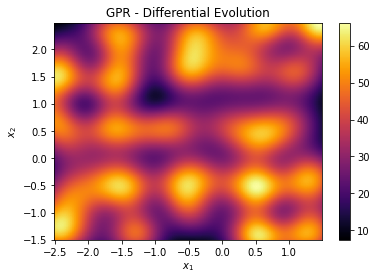

In [8]:
visualize_pred_meshgrid(gpr_de, "GPR - Differential Evolution")

In [9]:
n = 100
x_grid = np.linspace(-5, -0.75, n)
y_grid = np.linspace(-5, -0.75, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

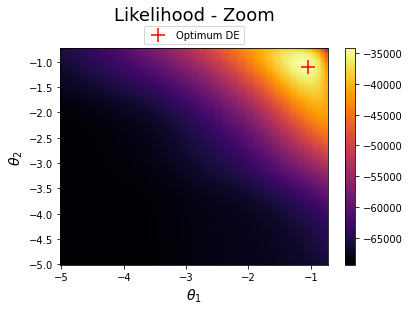

In [10]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum DE")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood - Zoom", y=1.1, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.125, 0, 0))

## GPR with Random Search

In [11]:
rs = RandomOptim(maxiter=100, visualize=True)
gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
gpr_rs.fit(X.T, y[...,None])
y_pred = gpr_rs.predict(X.T)
# from utils_clean import get_likelihood_grids
# x, y, z = get_likelihood_grids(gpr_rs)
# rs.visualize_optimization(x, y, z, "Random Search.mp4")

In [12]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_rs.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -60232.37943734049
          Mean Squared Error: 1.9686274913765865e-16
          R2 Score: 1.0
          MAPE: 1.396860755724285e-10



## GPR with PSO

In [13]:
seed = np.random.RandomState(42)
part = 10
dim = 2
pso = PSOOptim(n_iters=10, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=True)
gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
gpr_pso.fit(X.T, y[...,None])
y_pred = gpr_pso.predict(X.T)

2022-08-11 14:21:16,481 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.83e+4
2022-08-11 14:21:16,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 38292.12122593629, best pos: [-1.52969493 -0.87087197]


In [14]:
print(f'''Training Errors:
          Log Marginal Likelihood: {gpr_pso.log_marginal_likelihood_value_}
          Mean Squared Error: {mean_squared_error(y, y_pred)}
          R2 Score: {r2_score(y, y_pred)}
          MAPE: {mean_absolute_percentage_error(y, y_pred)}
''')

Training Errors:
          Log Marginal Likelihood: -38292.12122593629
          Mean Squared Error: 6.716407552257235e-17
          R2 Score: 1.0
          MAPE: 1.3565483488600293e-10



In [15]:
gpr_pso.kernel_.theta

array([-1.52969493, -0.87087197])

In [16]:
n = 100
x_grid = np.linspace(-10, 10, n)
y_grid = np.linspace(-10, 10, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

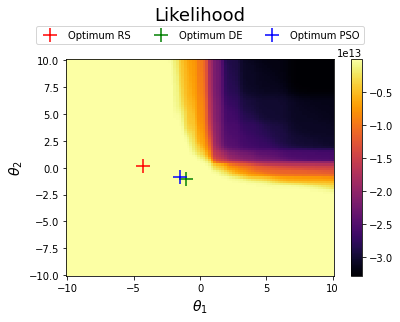

In [17]:
plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)

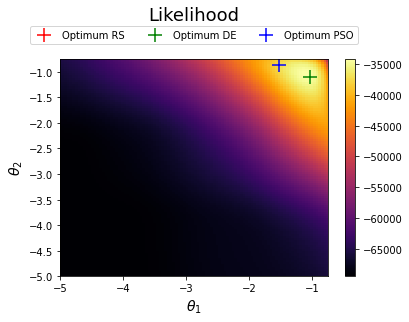

In [18]:
n = 100
x_grid = np.linspace(-5, -0.75, n)
y_grid = np.linspace(-5, -0.75, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(gpr_rs.kernel_.theta[0], gpr_rs.kernel_.theta[1], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(gpr_de.kernel_.theta[0], gpr_de.kernel_.theta[1], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.xlim(-5, -0.75)
plt.ylim(-5, -0.75)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)

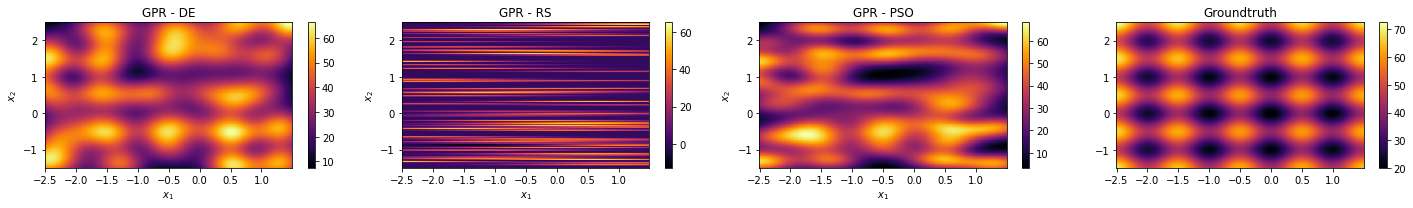

In [19]:
plt.figure(figsize=(20,3))
plt.subplot(141)
visualize_pred_meshgrid(gpr_de, "GPR - DE")
plt.subplot(142)
visualize_pred_meshgrid(gpr_rs, "GPR - RS")
plt.subplot(143)
visualize_pred_meshgrid(gpr_pso, "GPR - PSO")
plt.subplot(144)
m = np.arange(-2.5,1.5,0.001)
p = np.arange(-1.5,2.5,0.001)
visualize_meshgrid(m, p, target_func, title='Groundtruth')
plt.tight_layout()
plt.show()

100%|██████████| 10000/10000 [00:16<00:00, 588.28it/s]
2022-08-11 14:22:35,213 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2022-08-11 14:22:35,213 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


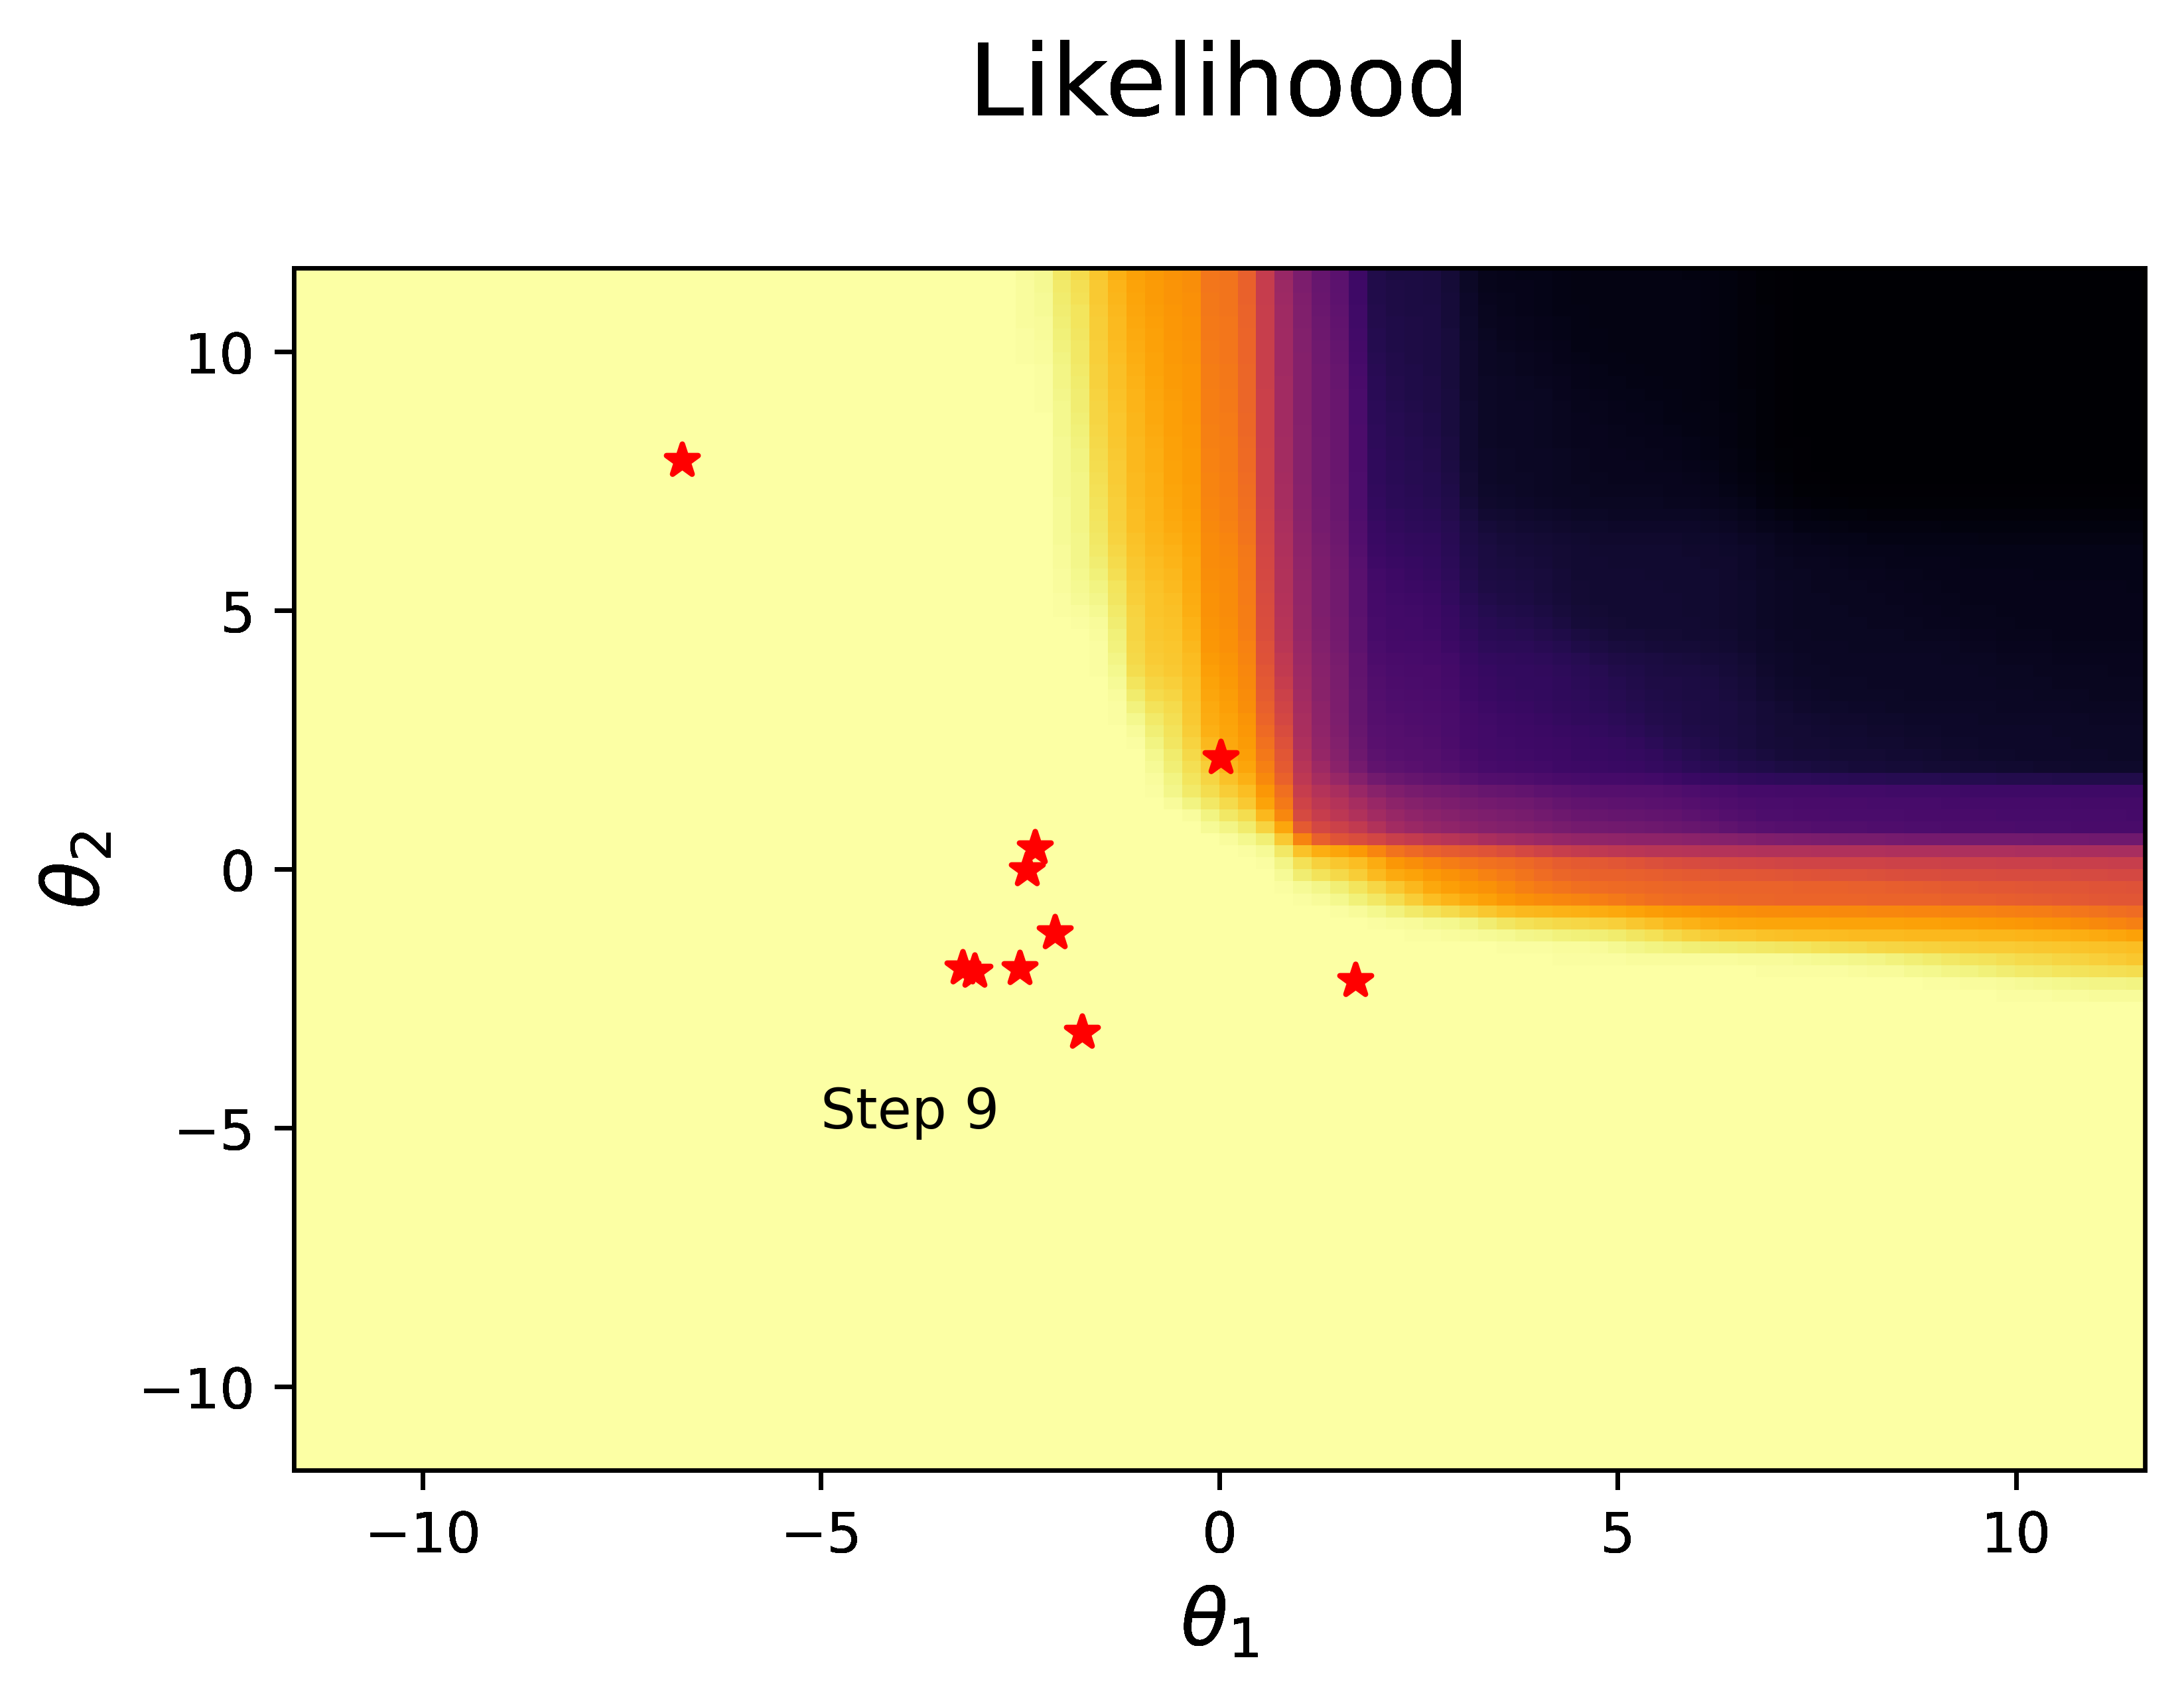

In [20]:
from utils import get_likelihood_grids
x_grid, y_grid, z_grid = get_likelihood_grids(gpr_pso)
pso.visualize_optimization(x_grid, y_grid, z_grid, "Videos/PSO.gif", show_zaeff=False)

In [21]:
import pandas as pd
df_iter_res = pd.DataFrame({"Iteration":[], "DE_t1":[], "PSO_t1":[], "RS_t1":[], "DE_t2":[], "PSO_t2":[], "RS_t2":[]})

for i in range(20):
    de = DEOptim()
    gpr_de = GaussianProcessRegressor(optimizer=de.optimize, kernel=RBF(length_scale=(1,1)))
    gpr_de.fit(X.T, y[...,None])

    pso = PSOOptim()
    gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
    gpr_pso.fit(X.T, y[...,None])

    rs = RandomOptim(random_state=i, maxiter=100)
    gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
    gpr_rs.fit(X.T, y[...,None])

    df_iter_res.loc[len(df_iter_res)] = [i, gpr_de.kernel_.theta[0], gpr_pso.kernel_.theta[0], gpr_rs.kernel_.theta[0], gpr_de.kernel_.theta[1], gpr_pso.kernel_.theta[1], gpr_rs.kernel_.theta[1]]
df_iter_res

2022-08-11 14:22:57,885 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=6.02e+4
2022-08-11 14:22:58,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 60161.50795068691, best pos: [ 7.43049534 -5.04812335]
2022-08-11 14:22:59,144 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=4.54e+4
2022-08-11 14:22:59,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45422.009984182485, best pos: [-0.36746861 -2.38404851]
2022-08-11 14:23:00,322 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=4.36e+4
2022-08-11 14:23:00,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 43605.0338660047

,Iteration,DE_t1,PSO_t1,RS_t1,DE_t2,PSO_t2,RS_t2
0,0.0,-1.039197,7.430495,3.688132,-1.096919,-5.048123,-4.833642
1,1.0,-1.039197,-0.367469,-3.991649,-1.096919,-2.384049,0.623036
2,2.0,-1.039197,-1.219743,-1.718482,-1.096919,-1.780415,-1.276225
3,3.0,-1.039197,-1.376150,-2.152458,-1.096920,-1.164888,-0.715177
4,4.0,-1.039197,-0.662627,-2.864974,-1.096919,-1.242487,0.058326
5,5.0,-1.039197,-1.366382,-0.936102,-1.096920,-1.517001,-1.873059
6,6.0,-1.039197,-0.565234,-1.139796,-1.096919,-2.307584,-2.905668
7,7.0,-1.039197,-1.002805,-2.938451,-1.096919,-1.608655,-0.520358
8,8.0,-1.039197,-1.505374,-1.500912,-1.096919,-1.200818,-1.577417
9,9.0,-1.039197,-1.154830,-0.507167,-1.096919,-0.941365,-1.483890


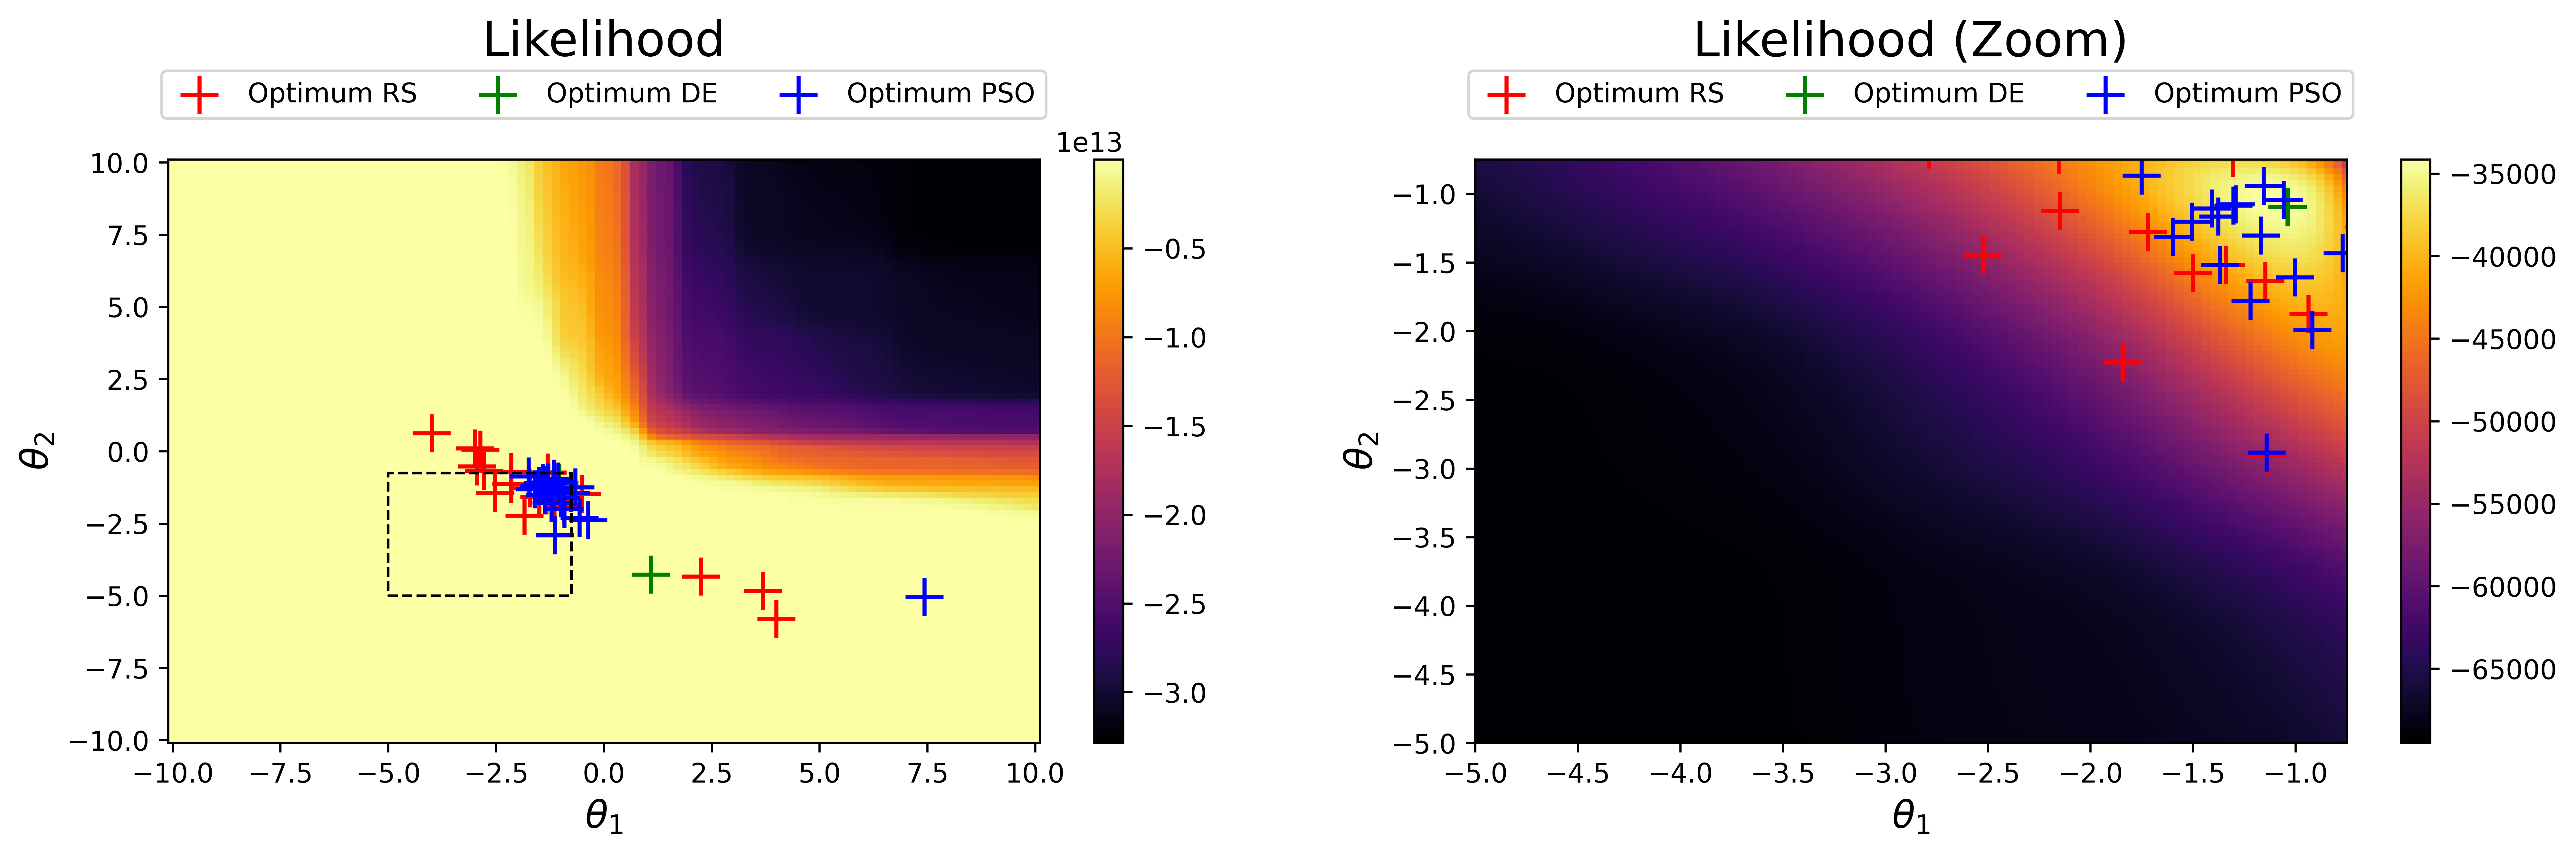

In [22]:
import matplotlib.patches as pt

plt.figure(figsize=(16,4), dpi=600)
plt.subplot(121)
n = 100
x_grid = np.linspace(-10, 10, n)
y_grid = np.linspace(-10, 10, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(df_iter_res["RS_t1"], df_iter_res["RS_t2"], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(df_iter_res["DE_t1"], df_iter_res["DE_t2"], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(df_iter_res["PSO_t1"], df_iter_res["PSO_t2"], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.title("Likelihood", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)
rect = pt.Rectangle(xy=(-5,-5), height=4.25, width=4.25, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")
plt.gca().add_patch(rect)

n = 100
x_grid = np.linspace(-5, -0.75, n)
y_grid = np.linspace(-5, -0.75, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))
z = np.asarray([gpr_de.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

plt.subplot(122)

plt.pcolormesh(x_grid, y_grid, z, cmap="inferno")
plt.colorbar()
plt.scatter(df_iter_res["RS_t1"], df_iter_res["RS_t2"], marker="+", color="red", s=200, label="Optimum RS")
plt.scatter(df_iter_res["DE_t1"], df_iter_res["DE_t2"], marker="+", color="green", s=200, label="Optimum DE")
plt.scatter(df_iter_res["PSO_t1"], df_iter_res["PSO_t2"], marker="+", color="blue", s=200, label="Optimum PSO")
plt.xlabel(r"$\theta_1$", fontsize=14)
plt.ylabel(r"$\theta_2$", fontsize=14)
plt.xlim(-5, -0.75)
plt.ylim(-5, -0.75)
plt.title("Likelihood (Zoom)", y=1.15, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175, 0, 0), ncol=3)
plt.show()

Likelihood Landscape 3D

Optimum:

In [23]:
import plotly.graph_objects as go

noise_scales = [1, 5, 10, 30, 50, 70]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
n_train_data_points = 70
n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

pso = PSOOptim(n_iters=100, n_particles=10, c1=0.5, c2=0.3, w=0.9, visualize=False)
gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))

X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func, noise_scale=0)
gpr_pso.fit(X.T, y[...,None])

n = 150
x_grid = np.linspace(-3, -0.7, n)
y_grid = np.linspace(-3, -0.7, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))

z = np.asarray([gpr_pso.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

fig = go.Figure(
    data=go.Surface(x=x_grid, y=y_grid, z=z, ),
    layout=go.Layout(
        title="Mt Bruno Elevation",
        width=500,
        height=500,
    ))
fig.update_layout(template="plotly",
                  title="Likelihood Landschaft",
                  scene = dict(
                  xaxis_title='$\theta_1$',
                  yaxis_title='$\theta_2$',
                  zaxis_title='Likelihood Value'))
fig.show()

2022-08-11 14:23:56,677 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.41e+4
2022-08-11 14:23:59,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34147.02193297705, best pos: [-1.0389087  -1.09861226]


Global View in Bounds

In [24]:
pso = PSOOptim(n_iters=100, n_particles=10, c1=0.5, c2=0.3, w=0.9, visualize=False)
gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))

X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func, noise_scale=0)
gpr_pso.fit(X.T, y[...,None])

n = 150
x_grid = np.linspace(-11.5, 11.5, n)
y_grid = np.linspace(-11.5, 11.5, n)
X_grid = np.array(np.meshgrid(x_grid, y_grid))
X_grid  = X_grid.swapaxes(0, 2)
X_grid = X_grid.reshape((-1, 2))

z = np.asarray([gpr_pso.log_marginal_likelihood(X) for X in X_grid])
z = z.reshape(n, n)

fig = go.Figure(
    data=go.Surface(x=x_grid, y=y_grid, z=z, ),
    layout=go.Layout(
        title="Mt Bruno Elevation",
        width=500,
        height=500,
    ))
fig.update_layout(template="plotly",
                  title="Likelihood Landschaft",
                  scene = dict(
                  xaxis_title='$\theta_1$',
                  yaxis_title='$\theta_2$',
                  zaxis_title='Likelihood Value'))
fig.show()

2022-08-11 14:24:31,529 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.41e+4
2022-08-11 14:24:33,464 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34147.043123226125, best pos: [-1.04112369 -1.09642149]
